# Investor Classifier, Part II
Welcome to the eleventh lesson! This Jupyter Notebook file is meant to accompany **L11 - Investor Classifier II.**

##### Harry - I will be adding commentary from the course and myself to help anyone follow the lesson

### 1. Redundant Features & Dummy Variables

**Lesson Workspace**

In [1]:
# Import NumPy, Pandas, Pyplot, and Seaborn
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn

In [2]:
# Create a new DataFrame with investor_data_2.csv
investor_data = pd.read_csv('.\\investor_data_2.csv')

# display first three rows
investor_data.head(3)

,investor,commit,deal_size,invite,rating,int_rate,covenants,total_fees,fee_share,prior_tier,invite_tier,tier_change,fee_percent,invite_percent
0,Goldman Sachs,Commit,300,40,2,Market,2,30,0.0,Participant,Bookrunner,Promoted,0.000000,0.133333
1,Deutsche Bank,Decline,1200,140,2,Market,2,115,20.1,Bookrunner,Participant,Demoted,0.174783,0.116667
2,Bank of America,Commit,900,130,3,Market,2,98,24.4,Bookrunner,Bookrunner,None,0.248980,0.144444


<font color = 'blue'> **EXERCISE 1.1** </font> Drop Function Exercise

In [3]:
# Remove the invite_tier, fee_share, and invite features
investor_data = investor_data.drop(['invite','fee_share','invite_tier'], axis=1)

# Display shape of dataframe: 7233 rows and 11 columns
investor_data.shape


(7233, 11)

<font color = 'blue'> **EXERCISE 1.2** </font> Dummy Variables Exercise

Convert **Categorical features** into **True/False** values in the form of **1** and **0**

In [4]:
# Create dummy variables
investor_data = pd.get_dummies(investor_data)

# Display shape of dataframe - should see increase in number of columns
investor_data.shape

(7233, 21)

In [5]:
#you will now notice new Series like the following
investor_data.head(1) 

,deal_size,rating,covenants,total_fees,fee_percent,invite_percent,investor_Bank of America,investor_Deutsche Bank,investor_Goldman Sachs,investor_MUFG Union,...,commit_Commit,commit_Decline,int_rate_Above,int_rate_Below,int_rate_Market,prior_tier_Bookrunner,prior_tier_Participant,tier_change_Demoted,tier_change_None,tier_change_Promoted
0,300,2,2,30,0.0,0.133333,0,0,1,0,...,1,0,0,0,1,0,1,0,0,1


<i>Harry - To help illustrate, notice the new columns with a prefix of "investor_"</i>

In [6]:
# For example investor_
investor_data.filter(regex='^investor_',axis=1).head(3) 

,investor_Bank of America,investor_Deutsche Bank,investor_Goldman Sachs,investor_MUFG Union,investor_Wells Fargo
0,0,0,1,0,0
1,0,1,0,0,0
2,1,0,0,0,0


**Lesson Workspace**

When you created your **dummy variables**, your target feature **commit** was split into `commit_Commit` and `commit_Decline`.
- Since these series are mirror images of each other, you only need one of them.

In [7]:
# Display columns that start with commit_
investor_data.filter(regex='^commit_',axis=1).head(3) 

,commit_Commit,commit_Decline
0,1,0
1,0,1
2,1,0


In [8]:
# Drop the commit_Commit Series from your DataFrame
# investor_data = investor_data.drop('commit_Commit', axis=1)
investor_data.drop('commit_Commit', axis=1, inplace=True) #Go with inplace

# Display shape of dataframe - should be one less column
investor_data.shape

(7233, 20)

In [9]:
# Define new DataFrames for your target variable and input features

# Target Variable we are trying to predict (Decline vs. Didn't Decline)
target = investor_data.commit_Decline

# Feature Set used to predict the Target variable
inputs = investor_data.drop('commit_Decline', axis=1) 

# I think it's worth showing the shapes of the two panda objects
print('Shape of target: {}  ; Shape of inputs: {}'.format(target.shape,inputs.shape))

Shape of target: (7233,)  ; Shape of inputs: (7233, 19)


### 2. Stratified Random Sampling

#### Comments:

When you **split your data** into **training** and **testing** sets, it's really important for each set to contain approximately equal proportions of commit and decline.
> I.E., Each set, your training and testing, should be representative of the data as a whole. 

The greater the difference between Positive and Negative classes, the more likely you are to accidentally create varying proportions in your training and testing data sets that could lead misleading results. 

You can solve this with **stratified random sampling**, or (also known as proportionate random sampling).
> - Stratified Random Sampling = separates your data into classes and randomly selects proportionate samples from each class
> - Use `stratify` option in the `train_test_split()`

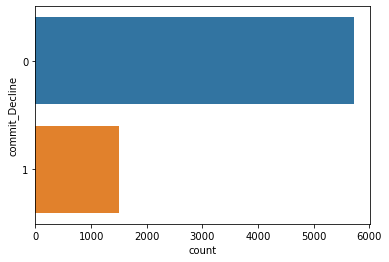

In [10]:
sns.countplot(y='commit_Decline', data=investor_data)
plt.show()

**Lesson Workspace** : With `stratify=investor_data.commit.commit_Decline`
- We can ensure the proportions of commit and decline in both the **training** data and **testing** data are representative of the data set as a whole

In [11]:
# Split your data using stratified random sampling
from sklearn.model_selection import train_test_split

split_list = train_test_split(inputs, target, 
                              test_size=0.2, 
                              random_state=1,
                              stratify=investor_data.commit_Decline
                             )


<font color = 'blue'> **EXERCISE 2.1** </font> Split Data Exercise

In [12]:
# Unpack split_list into four new objects and print their shapes

# X_train    X_test      y_train       y_test     
input_train, input_test, target_train, target_test = split_list

# Display the shape for each dataset
for item in [input_train, input_test, target_train, target_test] :
    print(item.shape)


(5786, 19)
(1447, 19)
(5786,)
(1447,)


### 3. Pipelines & Hyperparameter Grids

**Lesson Workspace**

In [13]:
# Import Scikit-Learn functions and classifiers
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

<font color = 'blue'> **EXERCISE 3.1** </font> Create Pipeline Dictionary Exercise

In [14]:
# Create your pipeline dictionary
pipelines = {
    'l1' : make_pipeline(StandardScaler(), LogisticRegression(penalty='l1', random_state=1, solver='liblinear')),
    'l2' : make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', random_state=1)),
    'rf' : make_pipeline(StandardScaler(), RandomForestClassifier(random_state=1)),
    'gb' : make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=1))
}


In [15]:
# To verify the pipelines were created correctly
for key, value in pipelines.items():
    print(key, type(value))

l1 <class 'sklearn.pipeline.Pipeline'>
l2 <class 'sklearn.pipeline.Pipeline'>
rf <class 'sklearn.pipeline.Pipeline'>
gb <class 'sklearn.pipeline.Pipeline'>


<font color = 'blue'> **EXERCISE 3.2** </font> Hyperparameter Tuning
1. **Logistic Regression Classifier** - Tune the $L_1$ and $L_2$ penalty factor
    1. Adjusting the `C` parameter in `LogisticRegressionClassifier()`
        1. `C`, default=1.0
        1. Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.
2. **Random Forest Classifier** - Tune the number of **strong learners** and maximum **number of features**      
3. **Gradient Boosting Classifier** - Tune the number of **weak learners**, the **learning rate** and the maximum **depth** of each decision tree

| Dictionary Name    	| Hyperparameter Name                         	| Hyperparameter Values           |||
| :--------------------	|:---------------------------------------------	|:---------:|:---------:|:---------:|
| l1_hyperparameter  	| 'logisticregression__C'                     	|   0.1  	|  1  	    |  10 	    |
| l2_hyperparameter  	| 'logisticregression__C'                     	|   0.1  	|  1  	    |  10 	    |
| rf_hyperparameters 	| 'randomforestclassifier__n_estimators'      	|   100  	| 200 	    |  -  	    |
|                    	| 'randomforestclassifier__max_features'      	| 'auto' 	| 0.3 	    | 0.6 	    |
| gb_hyperparameters 	| 'gradientboostingclassifier__n_estimators'  	|   100  	| 200 	    |  -  	    |
|                    	| 'gradientboostingclassifier__learning_rate' 	|  0.05  	| 0.1 	    | 0.2 	    |
|                    	| 'gradientboostingclassifier__max_depth'     	|    1   	|  3  	    |  5  	    |

In [16]:
# Create the hyperparameter grids and store them in a new dictionary

# Step 1: for each class model, create a dictionary of hyperparameter values
l1_hyperparameters = {
    'logisticregression__C' : [0.1, 1, 10]
}

l2_hyperparameters = {
    'logisticregression__C' : [0.1, 1, 10]
}

rf_hyperparameters = {
    'randomforestclassifier__n_estimators' : [100,200],
    'randomforestclassifier__max_features' : ['auto',0.3,0.6]
}
GradientBoostingClassifier
gb_hyperparameters = {
    'gradientboostingclassifier__n_estimators'  : [100,200],
    'gradientboostingclassifier__learning_rate' : [0.05, 0.1, 0.2],
    'gradientboostingclassifier__max_depth'     : [1,3,5]
}

# Step 2: Create a master dictionary of hyperparameters
hyperparameters = {
    'l1' : l1_hyperparameters,
    'l2' : l2_hyperparameters,
    'rf' : rf_hyperparameters,
    'gb' : gb_hyperparameters
}


In [17]:
for key in ['l1', 'l2', 'rf', 'gb'] :
    if key in hyperparameters :
        if type(hyperparameters[key]) is dict :
            print(key, 'was found, and it is a grid.')
        else :
            print(key, 'was found, but it is not a grid.')
    else :
        print(key, 'was not found.')

l1 was found, and it is a grid.
l2 was found, and it is a grid.
rf was found, and it is a grid.
gb was found, and it is a grid.


### 4. Cross-Validation

Steps:
1. Create **untrained models** for each model class
2. **Train** each model and **tune** hyperparameters
3. Use the trained model to make **predictions** based on the inputs from your testing data
4. Compare the predictions against the **actual target values** from your testing data to score each model

**Lesson Workspace**

In [18]:
# Import GridSearchCV
from sklearn.model_selection import GridSearchCV


<font color = 'blue'> **EXERCISE 4.1** </font> Cross-Validation Exercise

In [19]:
# Create a dictionary containing your untrained models
models = {}
for key in pipelines.keys():
    models[key] = GridSearchCV(
        pipelines[key],           # Pipeline object
        hyperparameters[key],     # Hyperparameter Gird for the model
        cv=5                      # number of folds
    )

<font color = 'blue'> **EXERCISE 4.2** </font> Fit Untrained Model

In [20]:
# Write a for loop to train your models
for key in models :
    models[key].fit(input_train, target_train)
    print(key, 'is trained and tuned.')

l1 is trained and tuned.
l2 is trained and tuned.
rf is trained and tuned.
gb is trained and tuned.


### 5. Model Selection

**Lesson Workspace**

In [21]:
# Print the confusion matrix for your L1 Logistic Regression model
from sklearn.metrics import confusion_matrix

pred = models['l1'].predict(input_test)
print(confusion_matrix(target_test, pred))


[[1124   22]
 [  23  278]]


In [22]:
# Import functions
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve and print L1 AUROC
fpr, tpr, threshold = roc_curve(target_test, pred)
print('l1')
print('AUROC = ', round(auc(fpr, tpr), 3))



l1
AUROC =  0.952


<font color = 'blue'> **EXERCISE 5.1** </font> AUROC Exercise

In [23]:
# Write a for loop that calculates and prints each model's AUROC
from sklearn.metrics import roc_curve, auc

for key in models.keys():
    pred = models[key].predict(input_test)
    fpr, tpr, threshold = roc_curve(target_test, pred)
    print(key)
    print('AUROC = ', round(auc(fpr, tpr), 4))
    print('---')



l1
AUROC =  0.9522
---
l2
AUROC =  0.9522
---
rf
AUROC =  0.9616
---
gb
AUROC =  0.9683
---


### Extra - Harry - AUROC for Gradient Boost

In [24]:
pred = models['gb'].predict(input_test)
print(confusion_matrix(target_test, pred))
fpr_grd, tpr_grd, threshold = roc_curve(target_test, pred)
print('gb')
print('AUROC = ', round(auc(fpr_grd, tpr_grd), 4))

[[1138    8]
 [  17  284]]
gb
AUROC =  0.9683


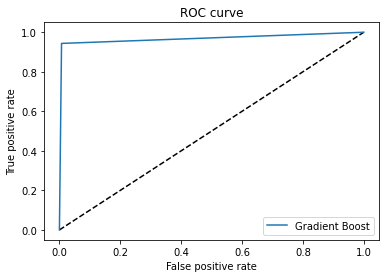

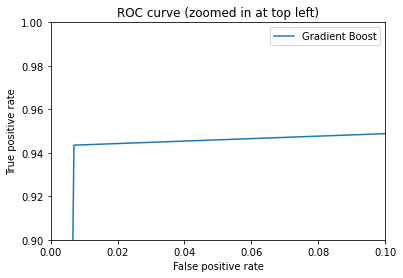

In [25]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_grd, tpr_grd, label='Gradient Boost')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.xlim(0, 0.1)
plt.ylim(0.9, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_grd, tpr_grd, label='Gradient Boost')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()